In [7]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_2dm as efc




/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


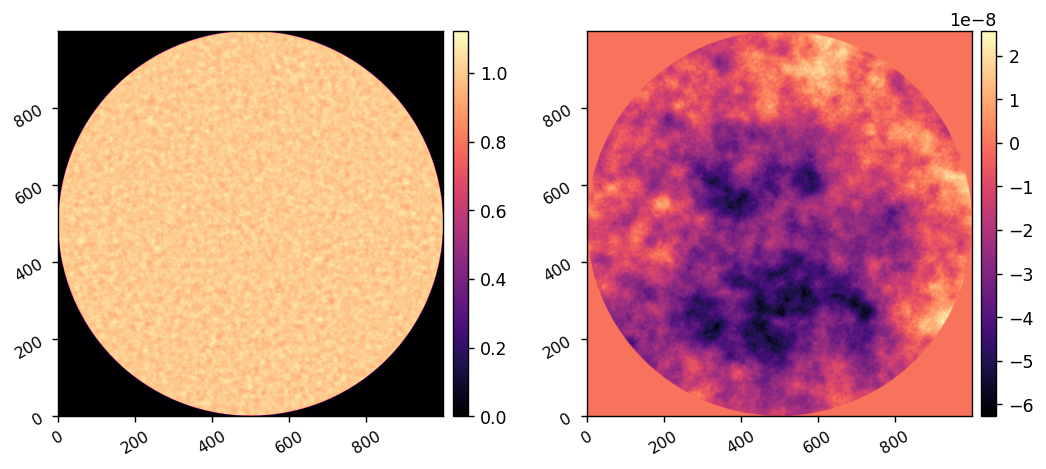

In [2]:
reload(fresnel)
Nact = 34
npsf = 128

I = fresnel.CORO(
    Nact=Nact,
    npsf=npsf,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


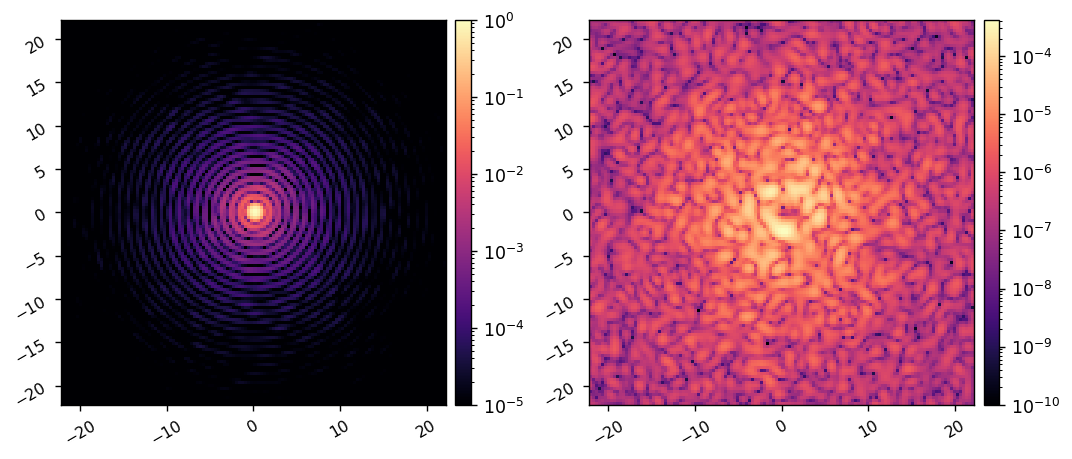

In [3]:
reload(fresnel)

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


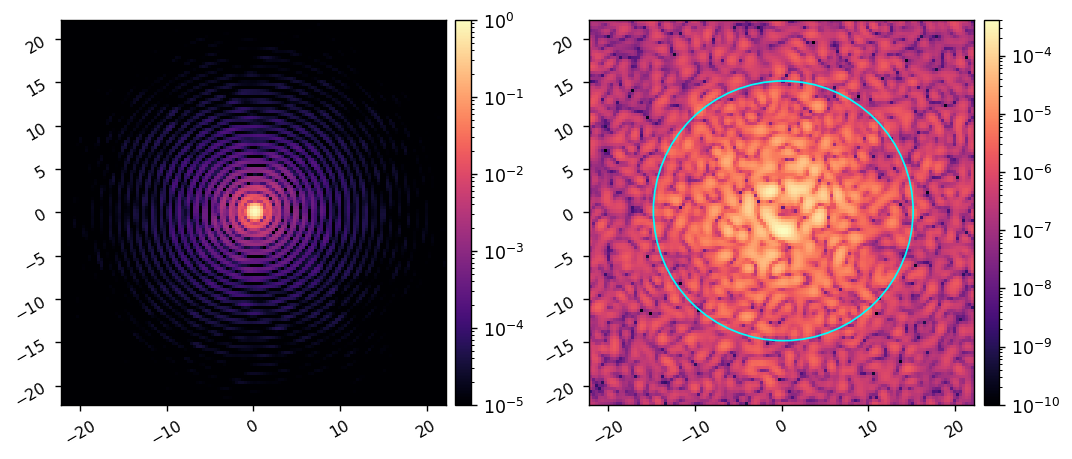

In [4]:
reload(fraunhofer)
M = fraunhofer.MODEL(
    Nact=Nact,
    npsf=npsf,
)
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(
    model_psf, model_coro_im,
    pxscl=M.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
    patches2=[Circle((M.psf_pixelscale_lamDc/2,M.psf_pixelscale_lamDc/2), M.control_rad, fill=False, color='cyan')]
)

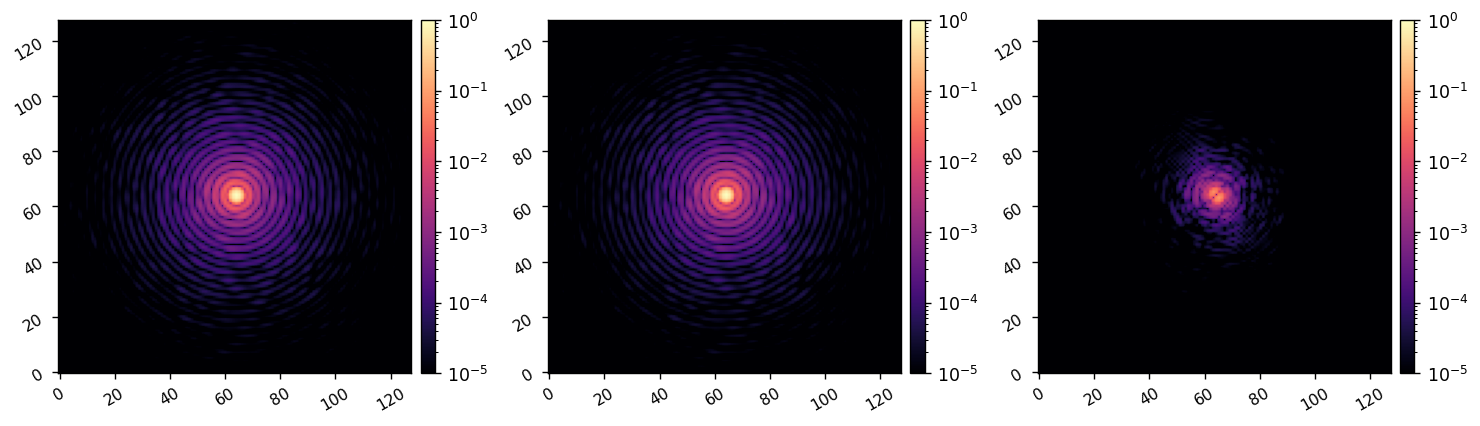

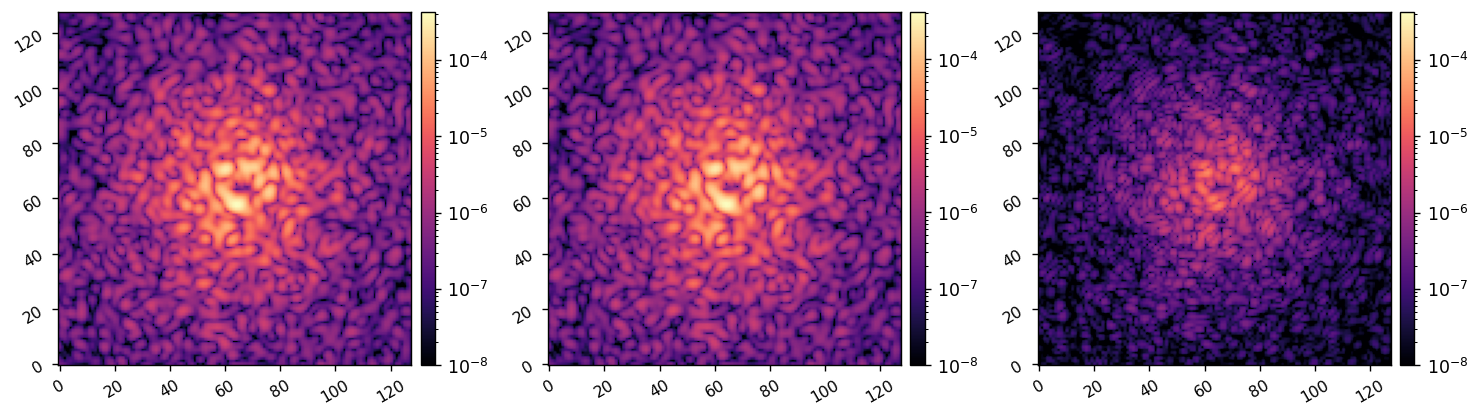

In [5]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

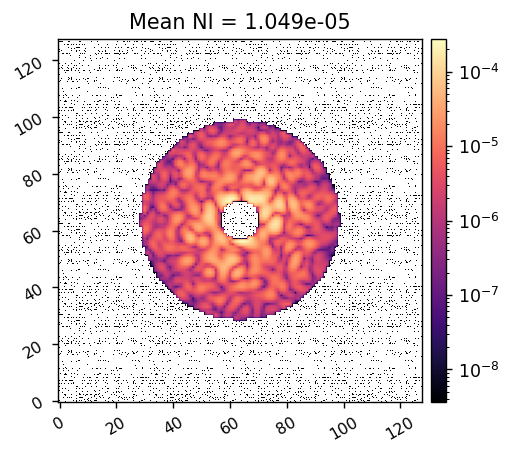

In [6]:
reload(utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

In [8]:
reload(efc)
jac = efc.compute_jacobian(
    M, 
    control_mask, 
    amp=1e-9, 
    # current_acts=current_acts, 
)

(7176, 1904)


In [9]:
utils.save_fits('jac.fits', jac)

Saved data to:  jac.fits


In [15]:
I.reset_dms()
data = {
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...
0


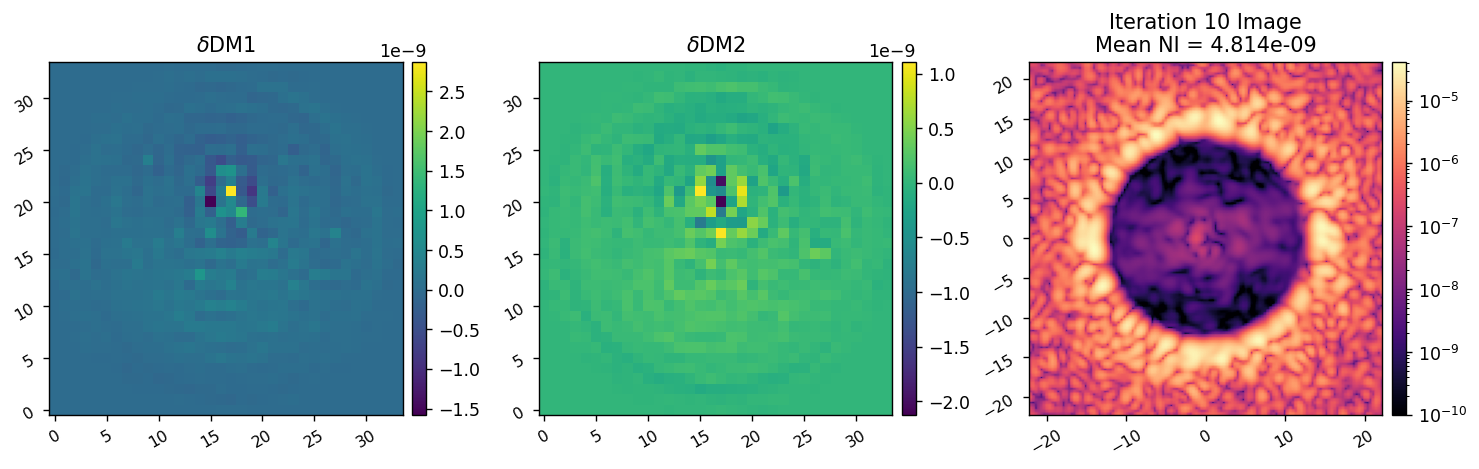

Computing E-field with model ...
1


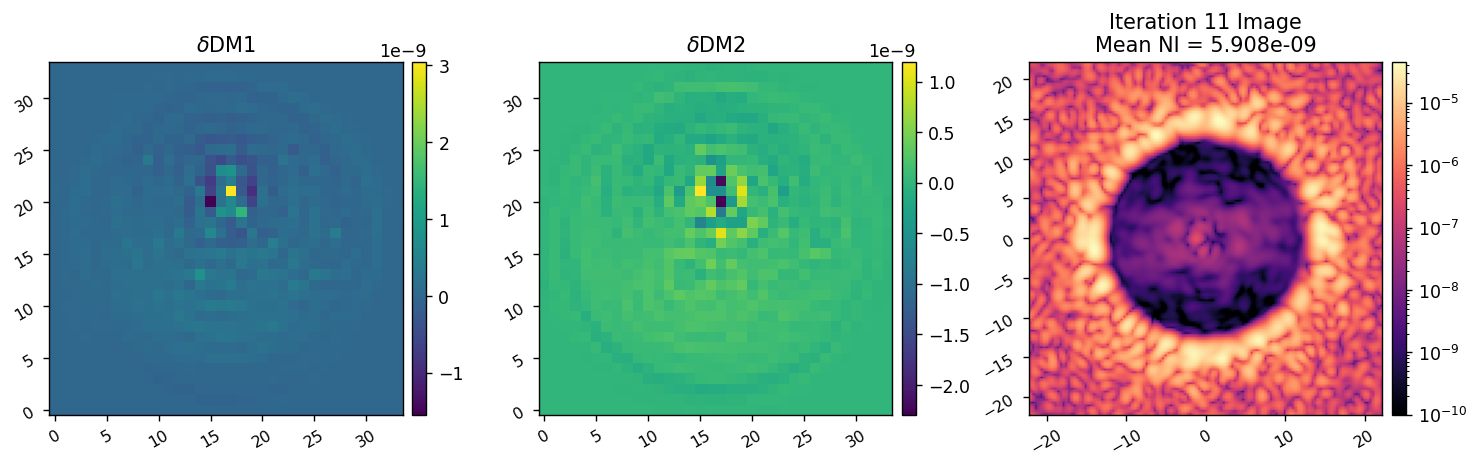

Computing E-field with model ...
2


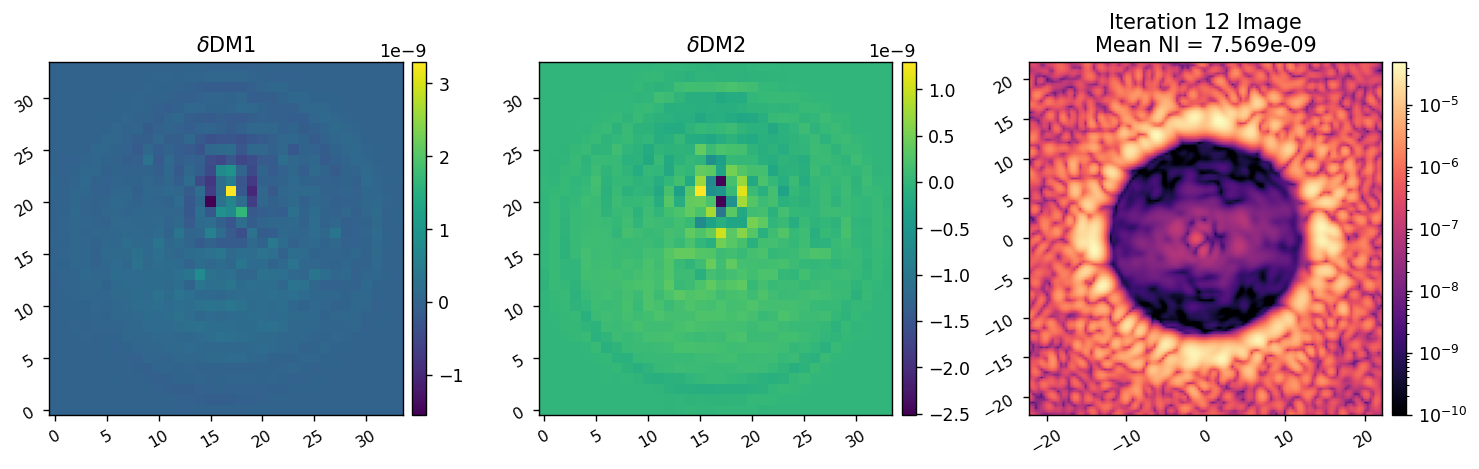

In [19]:
reload(fraunhofer)
reload(efc)

r_cond = -2
# r_cond = -3
# r_cond = -4
# r_cond = -5
# r_cond = -6

control_matrix = utils.beta_reg(jac, r_cond)

data = efc.run(
    I, 
    control_matrix,
    control_mask, 
    data,
    Nitr=3, 
    gain=1,
)

In [17]:
utils.save_pickle('aefc_34_data.pkl', data)

Saved data to:  aefc_34_data.pkl
